**First Step: import libraries**

In this step we import the necessary libraries to perform the image processing later on

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

**Second Step: Calibrate camera**

In this step, the camera is calibrated using multiple pictures of a chess board in different perspectives.
The calibration function takes the object points (defined as a grid (0,0,0), (1,0,0), etc) and image points (identified using cv2.findchessboardcorders) to calculate the transformation matrix used for undisturbing images

In [7]:
# Set chess field parameters
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# load images from directory
for fname in glob.glob("./camera_cal/*.jpg"):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points & image points for camera calibartion
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# set image size to calculate camera calibration
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

** Third Step: visualize undistortion**
In this step, we visualize the undistortion on one of the chessboard images to prove our calibration was successful.

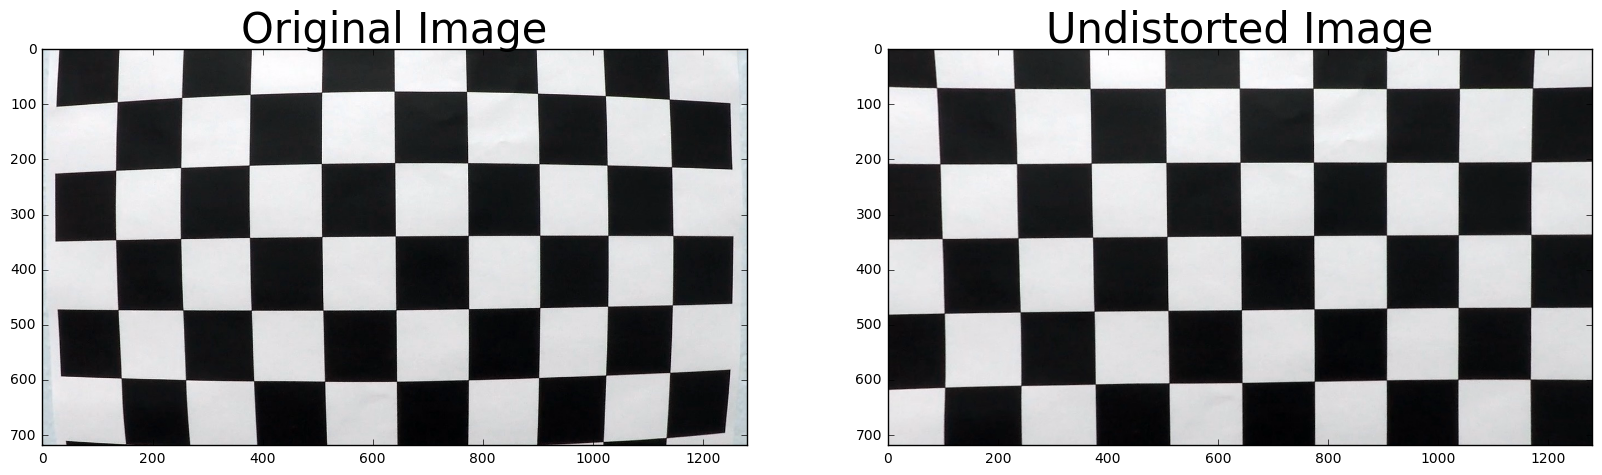

In [8]:
# Test undistortion on an image
img = cv2.imread("camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

** Fourth step: Defining the processing pipeline**

In this step we define the function to process the images (i.e. steps that will be performed for each frame of the video). In particular these steps are:
- Convert to HLS color space
- Split out L & S space
- Perform Sobel transformation on L-channel & create binary image --> sxbinary
- Perform simple threshold binary masking on S-channel --> s_binary
- Combine two binary images (sxbinary & s_binary)

In [9]:
def pre_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), M=None):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel transform in x-direction on L-channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    warped_binary = np.maximum(sxbinary, s_binary)
    
    if M!=None:
        img_size = (img.shape[1], img.shape[0])
        warped_binary = cv2.warpPerspective(warped_binary, M, img_size, flags=cv2.INTER_LINEAR)
        return (color_binary, warped_binary)
    else:
        return (color_binary, warped_binary)

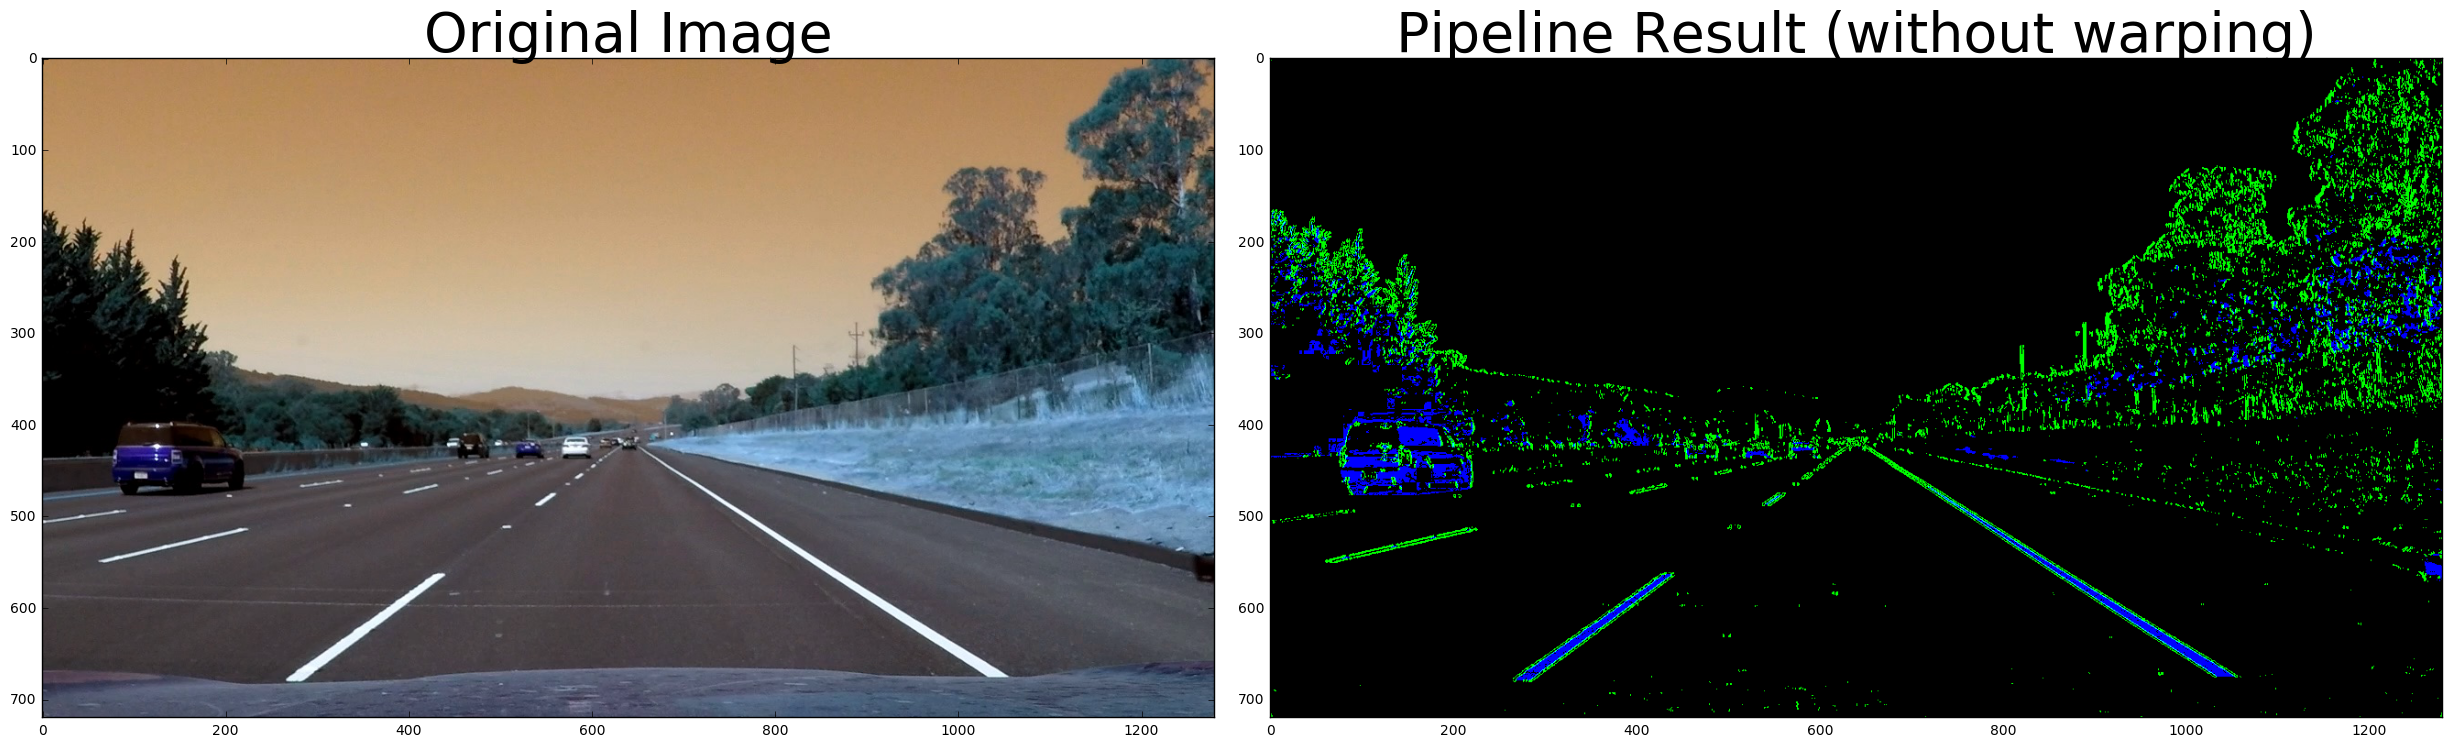

In [10]:
# Test pipeline without warping (don't provide M to the function)
img = cv2.imread("test_images/straight_lines2.jpg")
color_binary, warped_binary = pre_pipeline(img)

cv2.imwrite('output_images/pipeline_nowarp.jpg',dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Pipeline Result (without warping)', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

** Fifth step: Calculate transformation matrix for warping**
In the next step, we take the undistorted image and warp it. For this we pick specific points (based on pixels from the straing_lines1.jpg --> src) and map them to predefined coordinates using an offset from the corners (--> dst). These points are used to calculate the transform matrix M which is subsequently added to the dist_pickle and saved

source: 
[[  580.           460.        ]
 [  203.33332825   720.        ]
 [ 1106.66662598   720.        ]
 [  700.           460.        ]]
destionation: 
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


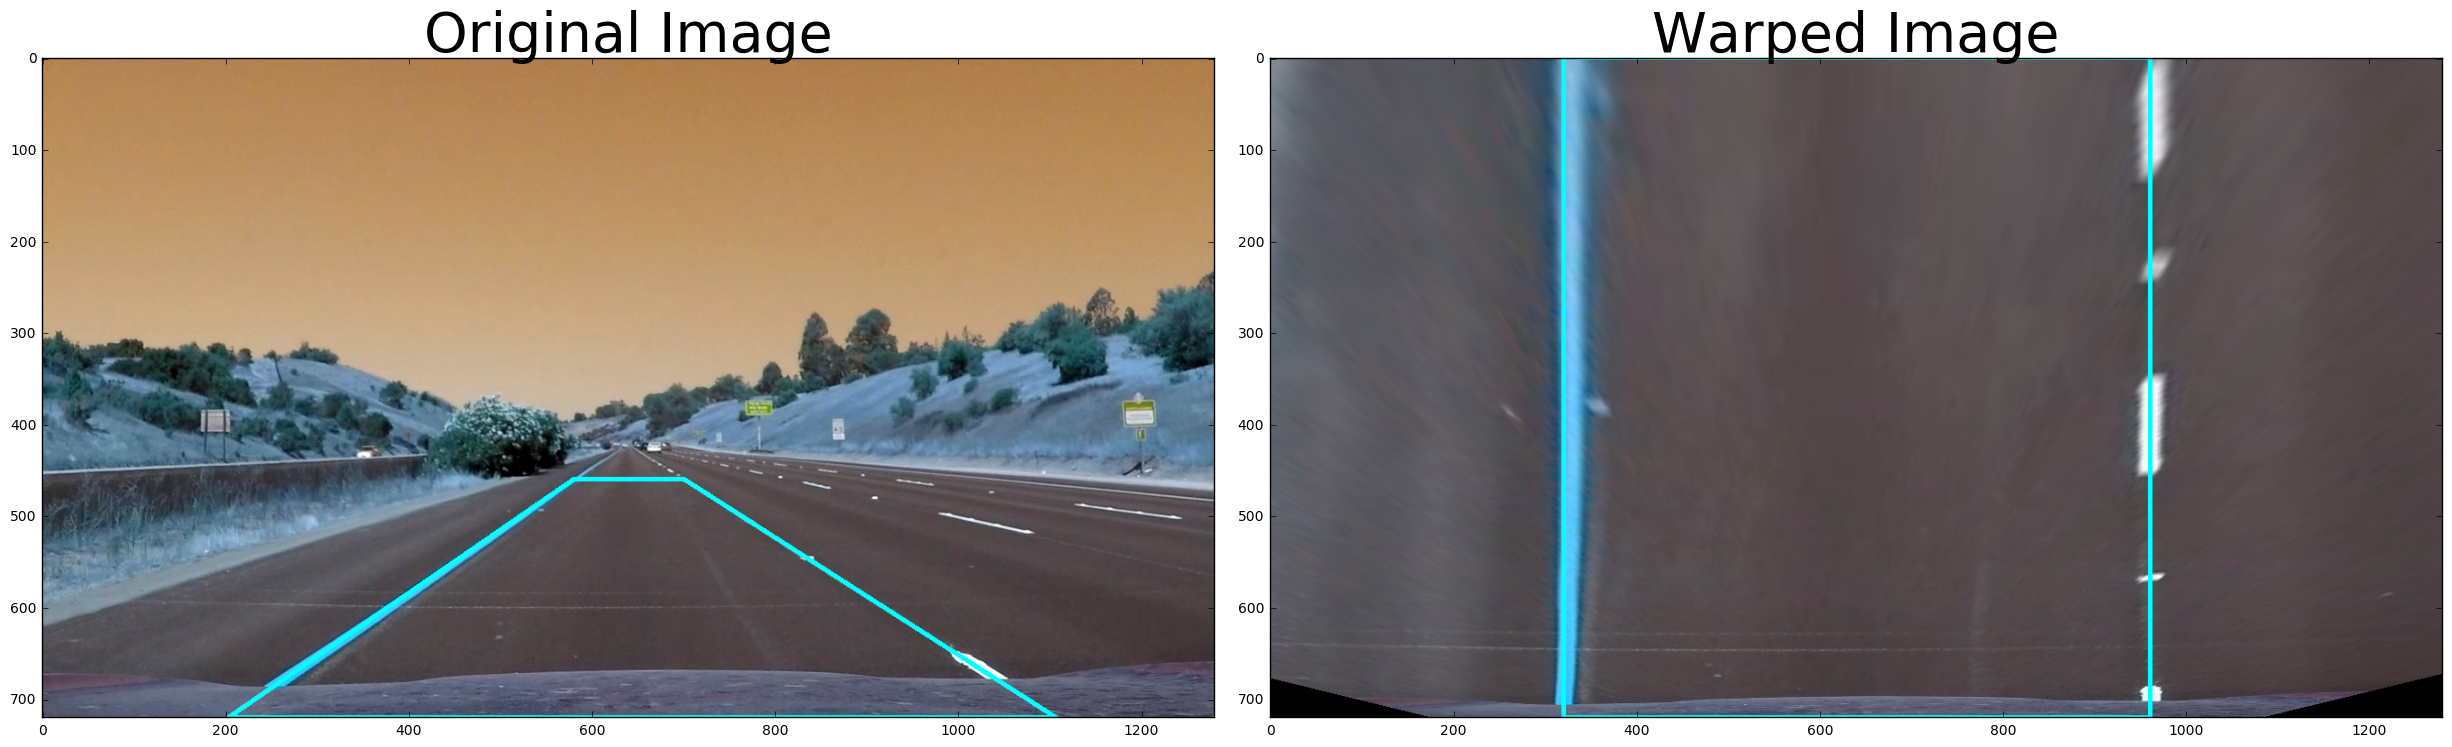

In [11]:
img = cv2.imread("test_images/straight_lines1.jpg")

# Undistort using mtx and dist
undist = cv2.undistort(img, mtx, dist, None, mtx)

# define 4 source points & destination points 

src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# use cv2.getPerspectiveTransform() to get M, the transform matrix & save to pickle
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )


# print source & destination points for mapping
print("source: ")
print(src)
print("destionation: ")
print(dst)


# overlay source points
src_pts = np.array(src, np.int32)
imcopy = np.copy(img)
cv2.polylines(imcopy, [src_pts], True, (0,255,255), 3)

# calculate warped image
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# overlay destination points
dst_pts = np.array(dst, np.int32)
cv2.polylines(warped, [dst_pts], True, (0,255,255), 3)

# display original & warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imcopy)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

C:\Users\andreas.hejj\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


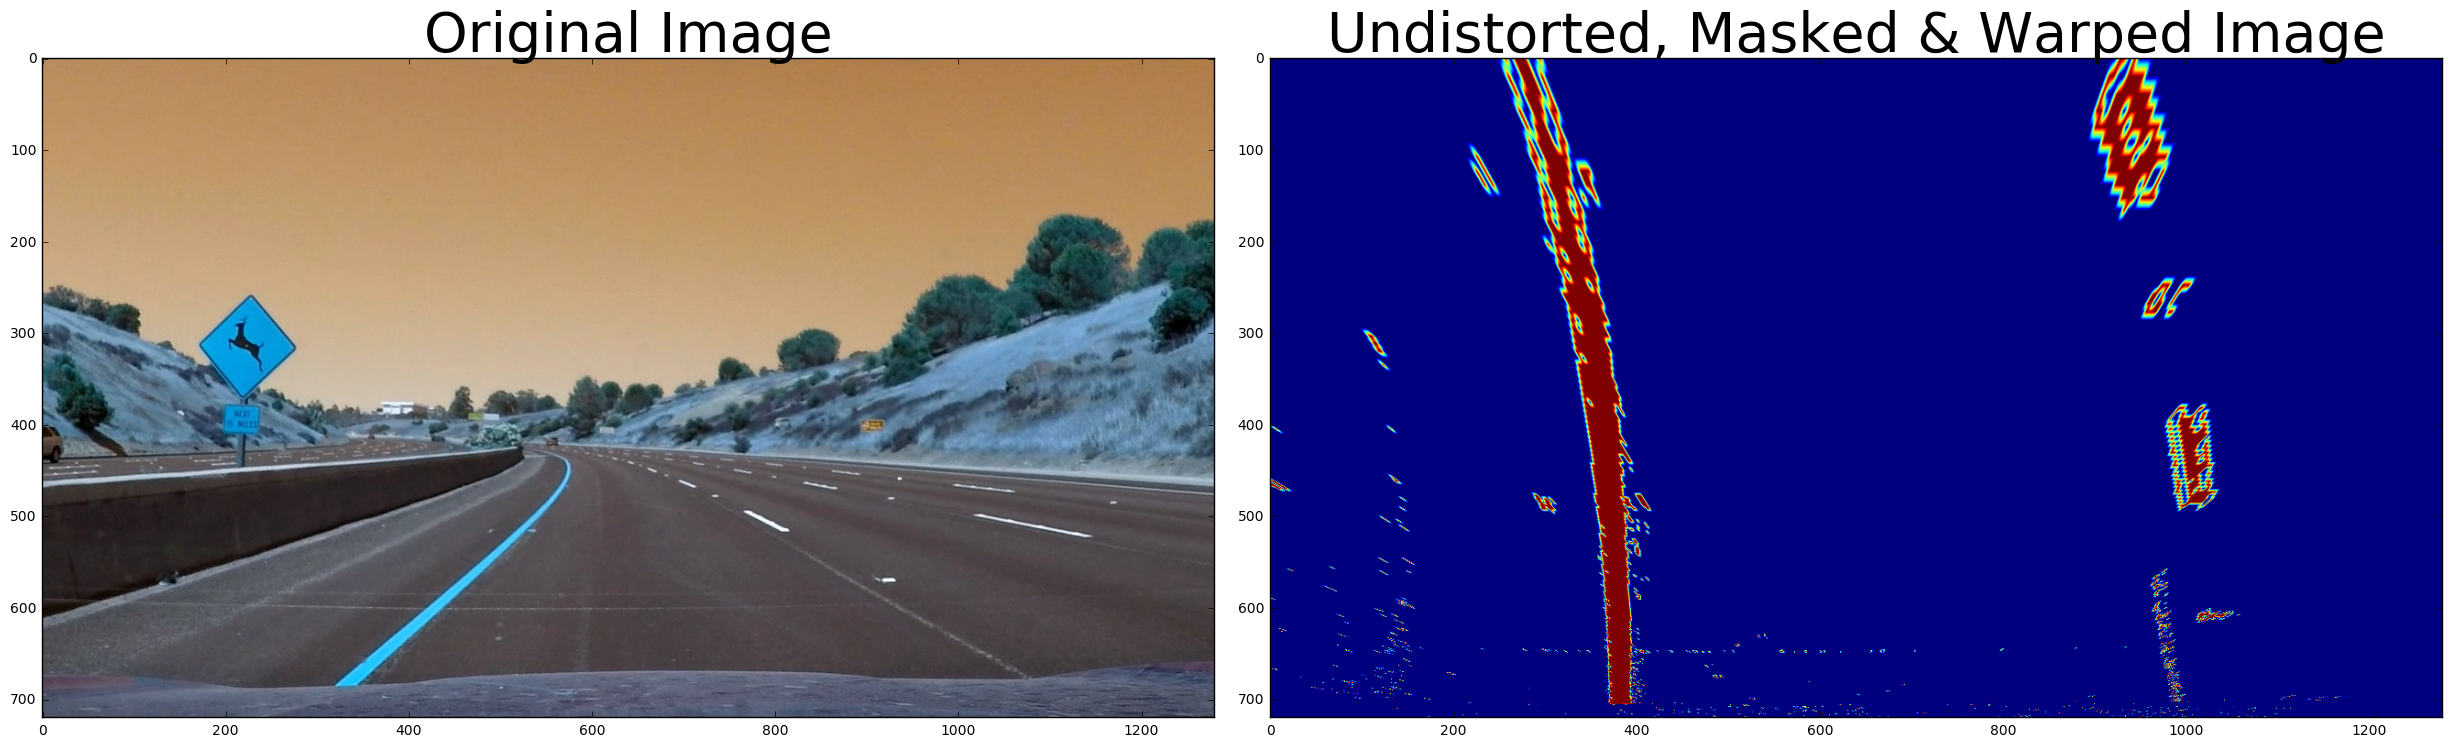

In [12]:
# Test pipeline incl. warping (provide M to the function)
img = cv2.imread("test_images/test2.jpg")
color_binary, warped_binary = pre_pipeline(img, M=M)

cv2.imwrite('output_images/pipeline_warp.jpg',warped_binary)
                 
# display warping results on sample image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped_binary)
ax2.set_title('Undistorted, Masked & Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

** Sixth step: Find lane lines using sliding window**

In this step we define a window that we slide over the image to find the lane lines in the processed image

In [191]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def find_lanes(binary_warped, line_left, line_right):
     # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    if (not line_left.detected) | (not line_right.detected):
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
   
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        line_left.detected = True
        line_right.detected = True
    else:
        left_lane_inds = ((nonzerox > (line_left.current_fit[0]*(nonzeroy**2) + line_left.current_fit[1]*nonzeroy + line_left.current_fit[2] - margin)) & 
                          (nonzerox < (line_left.current_fit[0]*(nonzeroy**2) + line_left.current_fit[1]*nonzeroy + line_left.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (line_right.current_fit[0]*(nonzeroy**2) + line_right.current_fit[1]*nonzeroy + line_right.current_fit[2] - margin)) & 
                           (nonzerox < (line_right.current_fit[0]*(nonzeroy**2) + line_right.current_fit[1]*nonzeroy + line_right.current_fit[2] + margin)))  
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    line_left.current_fit = np.polyfit(lefty, leftx, 2)
    line_right.current_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    line_left.ally = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    line_left.allx = line_left.current_fit[0]*line_left.ally**2 + line_left.current_fit[1]*line_left.ally + line_left.current_fit[2]
    
    # put allx into xfitted and calculate avg x over last 10 iterations
    line_left.recent_xfitted.append([line_left.allx])
    if (len(line_left.recent_xfitted)> 10 ):
        line_left.recent_xfitted.pop(0)
    line_left.bestx = np.mean(line_left.recent_xfitted, axis=0)[0]
    
    # Generate x and y values for plotting
    line_right.ally = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
    line_right.allx = line_right.current_fit[0]*line_right.ally**2 + line_right.current_fit[1]*line_right.ally + line_right.current_fit[2]
    
    # put allx into xfitted and calculate avg x over last 10 iterations
    line_right.recent_xfitted.append([line_right.allx])
    if (len(line_right.recent_xfitted)> 10 ):
        line_right.recent_xfitted.pop(0)
    line_right.bestx = np.mean(line_right.recent_xfitted, axis=0)[0]
    
    
    # Fit a second order polynomial to each
    line_left.current_fit = np.polyfit(line_left.ally, line_left.bestx, 2)
    line_right.current_fit = np.polyfit(line_right.ally, line_right.bestx, 2)
    
    # Generate x and y values for plotting
    line_left.allx = line_left.current_fit[0]*line_left.ally**2 + line_left.current_fit[1]*line_left.ally + line_left.current_fit[2]
    line_right.allx = line_right.current_fit[0]*line_right.ally**2 + line_right.current_fit[1]*line_right.ally + line_right.current_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(binary_warped.shape[0])
    
   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate distance in meters of vehicle center from the line
    left_bottom = line_left.allx[700]
    right_bottom = line_right.allx[700]
    lane_mid = (left_bottom + right_bottom )/2
    x_mid = np.max(binary_warped.shape[1])/2    
    
    line_left.line_base_pos = abs( x_mid - lane_mid) * xm_per_pix
    line_right.line_base_pos = abs( x_mid - lane_mid) * xm_per_pix

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    line_left.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    line_right.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    line_left.radius_of_curvature = (line_left.radius_of_curvature + line_right.radius_of_curvature) /2
    line_right.radius_of_curvature = (line_left.radius_of_curvature + line_right.radius_of_curvature) /2

753.549994876
0.258408145583


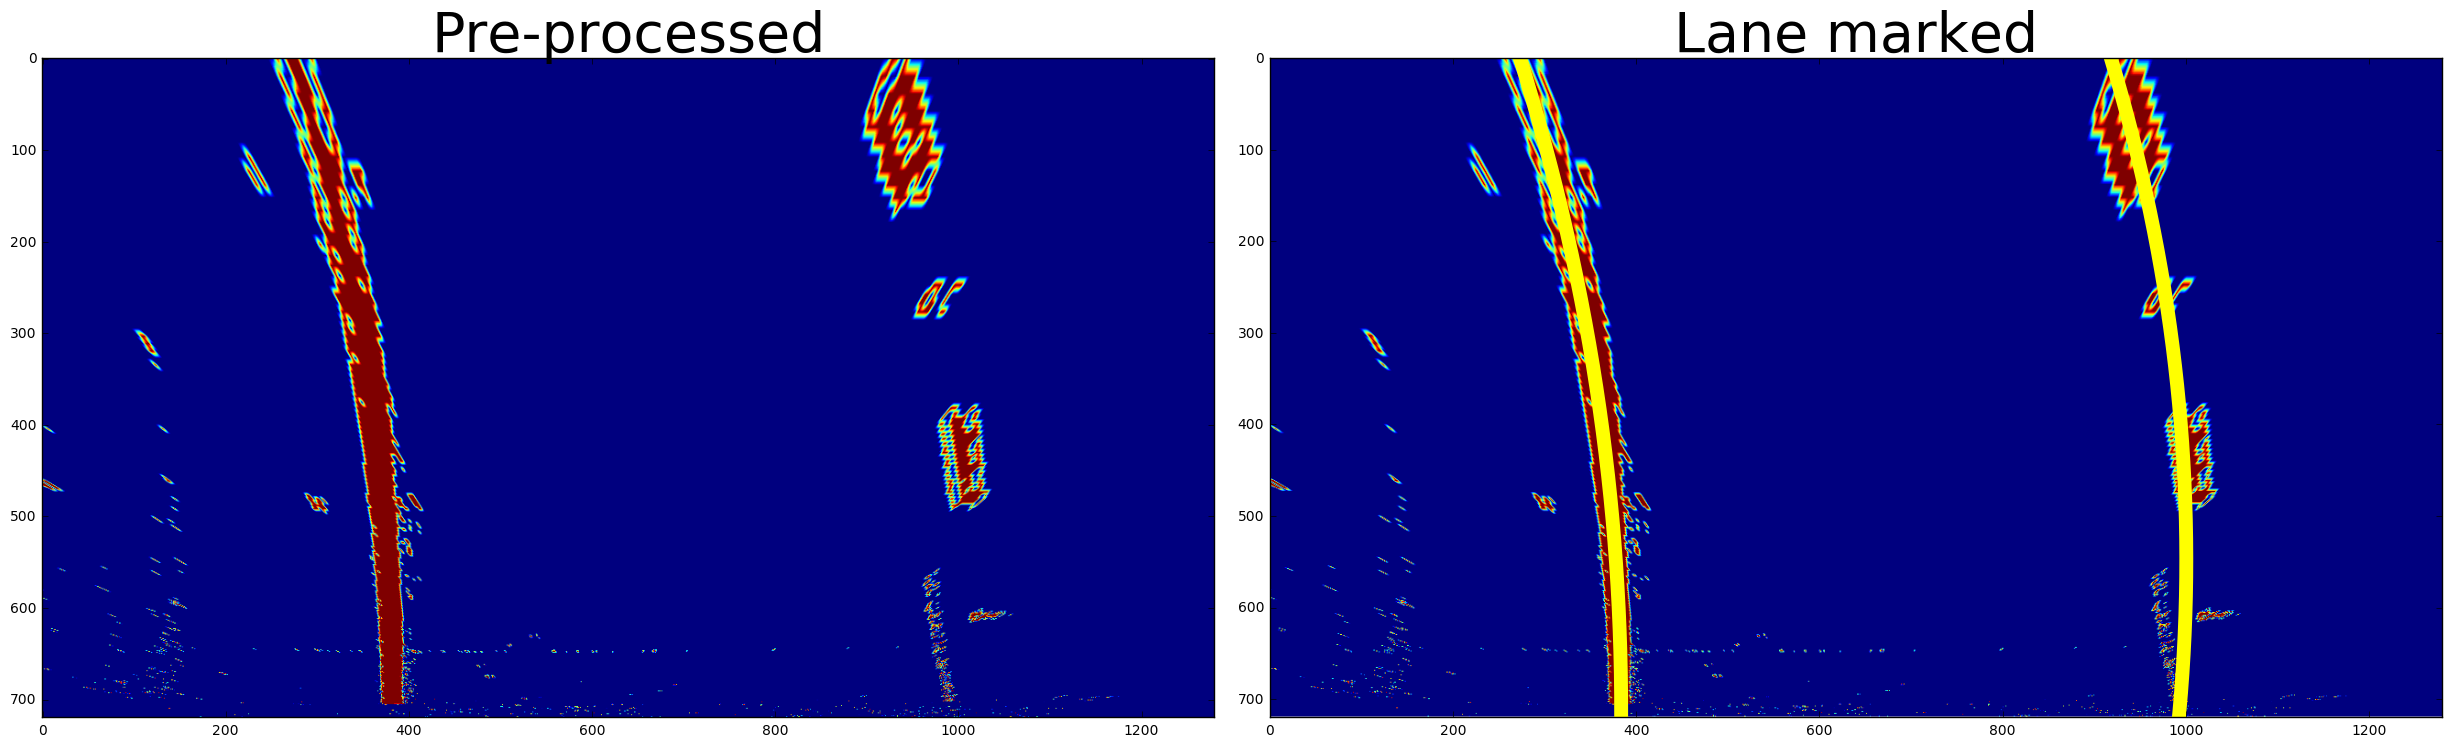

In [206]:
img = cv2.imread("test_images/test2.jpg")

color_binary, binary_warped = pre_pipeline(img, M=M)
line_left = Line()
line_right = Line()

find_lanes(binary_warped, line_left, line_right)

print(line_left.radius_of_curvature)
print(line_left.line_base_pos)

# display warping results on sample image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped)
ax1.set_title('Pre-processed', fontsize=40)
ax2.imshow(binary_warped)

plt.plot(line_left.allx, line_left.ally, color='yellow', linewidth=10)
plt.plot(line_right.allx, line_right.ally, color='yellow',  linewidth=10)
plt.xlim(0, 1280)
plt.ylim(720, 0)
ax2.set_title('Lane marked', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [197]:
def post_pipeline(image, warped, line_left, line_right):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([line_left.allx, line_left.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line_right.allx, line_right.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, "RADIUS --> %d m" % (line_left.radius_of_curvature) ,(300,100), font, 1,(255,255,255),2)
    cv2.putText(result, "DIST FROM CENTER --> %.2f m " % (line_left.line_base_pos) ,(300,200), font, 1,(255,255,255),2)
    
    return result

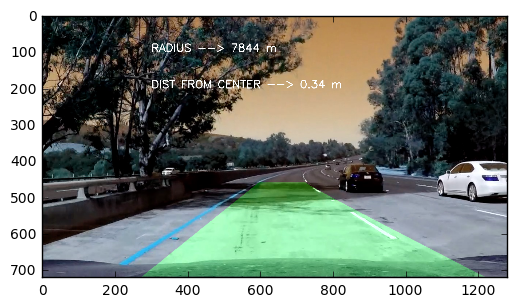

In [198]:
img = cv2.imread("test_images/test5.jpg")

color_binary, binary_warped = pre_pipeline(img, M=M)
find_lanes(binary_warped, line_left, line_right)

result = post_pipeline(img, binary_warped, line_left, line_right)

plt.imshow(result)
plt.show()

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [35]:
def process_image(img):
    color_binary, binary_warped = pre_pipeline(img, M=M)
    find_lanes(binary_warped, line_left, line_right)
    return post_pipeline(img, binary_warped, line_left, line_right)

In [201]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_left = Line()
line_right = Line()

project_output = 'harder_challenge_output.mp4'
clip = VideoFileClip("harder_challenge_video.mp4")
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:44<00:00,  6.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

Wall time: 3min 47s
